# Training and Evaluating Logistic Regression Model on Encrypted data 

in this notebook we are going to use Homomorphic Encryption to encrypt data before giving it to the LR model for evaluation, and for this we are going to use the HE Lib TenSEAL 

In [3]:
import torch as th 
import tenseal as ts 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import secrets
import random

we are going to use the **heart disease prediction** from kaggle.

In [15]:
def split_train_test(x,y,test_ratio=0.3):
    indx = [i for i in range(len(x))]
    random.shuffle(indx)
    test_size = int(len(x) * test_ratio) 
    test_indices, train_indices = indx[:test_size] ,indx[test_size:]
    return x[train_indices], y[train_indices], x[test_indices],y[test_indices]

In [5]:
x_train,y_train,x_test,y_test  = split_train_test()

[7, 4, 1, 56, 3, 5, 6, 2]

In [12]:
int(128 * 0.3)

38

In [75]:
dataset = pd.read_csv("./data/framingham.csv")
# drop all the rows that contains nan values
dataset = dataset.dropna()
# drop some useless features
dataset = dataset.drop(["education","currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"],axis=1)
#groupe the data by TenYearCHD 
grouped = dataset.groupby('TenYearCHD')
dataset = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
y = th.tensor(dataset["TenYearCHD"].values).float().unsqueeze(1)
dataset = dataset.drop("TenYearCHD",axis=1)
dataset = (dataset - dataset.mean())/dataset.std()
x = th.tensor(dataset.values).float()

In [76]:
x_train,y_train,x_test,y_test = split_train_test(x,y)

In [77]:
x_train.shape

torch.Size([780, 9])

## Training the LogReg Model

In [89]:
class LogReg(th.nn.Module): 
    def __init__(self,n_feat):
        super(LogReg,self).__init__()
        self.linear = th.nn.Linear(n_feat,1)
    def forward(self,x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

In [113]:
n_features = x_train.shape[1]
model = LogReg(n_features)
optim = torch.optim.SGD(model.parameters(),lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [114]:
def train (epochs,model,x_train,y_train,optim,metric):
    for epoch in range(1,epochs+1) :
        optim.zero_grad()
        out = model(x_train)
        loss = metric(out,y_train)
        loss.backward()
        optim.step()
        print(f"epoch : {epoch} loss : {loss}")
    return model

In [117]:
model = train(50,model,x_train,y_train,optim,criterion)

epoch : 1 loss : 0.5855586528778076
epoch : 2 loss : 0.5855574607849121
epoch : 3 loss : 0.5855565071105957
epoch : 4 loss : 0.5855557322502136
epoch : 5 loss : 0.5855551362037659
epoch : 6 loss : 0.5855545401573181
epoch : 7 loss : 0.5855540633201599
epoch : 8 loss : 0.5855537056922913
epoch : 9 loss : 0.5855533480644226
epoch : 10 loss : 0.5855530500411987
epoch : 11 loss : 0.5855528712272644
epoch : 12 loss : 0.5855526328086853
epoch : 13 loss : 0.585552453994751
epoch : 14 loss : 0.5855523347854614
epoch : 15 loss : 0.5855522155761719
epoch : 16 loss : 0.5855521559715271
epoch : 17 loss : 0.5855520367622375
epoch : 18 loss : 0.5855519771575928
epoch : 19 loss : 0.5855518579483032
epoch : 20 loss : 0.5855517983436584
epoch : 21 loss : 0.5855517983436584
epoch : 22 loss : 0.5855516791343689
epoch : 23 loss : 0.5855516195297241
epoch : 24 loss : 0.5855516195297241
epoch : 25 loss : 0.5855515599250793
epoch : 26 loss : 0.5855515599250793
epoch : 27 loss : 0.5855515599250793
epoch : 28 

In [183]:
def accuracy(model,x_test,y_test): 
    out = model(x_test)
    correct = torch.abs(y_test - out) < 0.5
    return correct.float().mean()

In [219]:
plain_accuracy = accuracy(model, x_test,y_test)
print(f"the accuracy on plain data is : {accuracy(model, x_test,y_test)}")

the accuracy on plain data is : 0.6796407103538513


## Encrypted Evaluation

In [260]:
class HELogReg:
    def __init__(self,torch_LogReg):
        self.weight = torch_LogReg.weight.t().tolist()
        self.bias = torch_LogReg.bias.t().tolist()
    def forward(self,enc_x):
        weight = np.array(self.weight).squeeze(1)
        return enc_x.dot(weight) + self.bias

    def __call__(self,*args,**keys): 
        return self.forward(*args,**keys)
    

In [261]:
he_model = HELogReg(model.linear)

now we will create the context for the encryption

In [262]:
bit_scale = 20
polynomial_modulus_degree = 8192
coeff_mod_bit_sizes = [40,bit_scale,bit_scale,40]
context = ts.context(ts.SCHEME_TYPE.CKKS,polynomial_modulus_degree, coeff_mod_bit_sizes  =coeff_mod_bit_sizes)
context.global_scale = 2**bit_scale

context.generate_galois_keys()

In [263]:
#encrypting the test data 
enc_x_test = [ts.ckks_vector(context,x.tolist()) for x in x_test]


We are not using the sigmoid fonction in the HE model for reducing the computation time, but we will use it in the evaluation process

In [272]:
def ecnryption_evaluation(model,enc_x_test,y_test): 
    start = time()
    correct = 0
    for enc_x , y in zip(enc_x_test,y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(y -out) < 0.5 : 
            # correct value
            correct +=1
    end = time()
    print(f"The evaluation process of {len(enc_x_test)} entries took : {end- start} seconds.")
    print(f"The accuracy of ecrypted data is : {correct/len(enc_x_test)}")
    return correct / len(enc_x_test)

In [273]:
encrypted_acc = ecnryption_evaluation(he_model,enc_x_test,y_test)
print(f"Accuracy of the plain data is : {plain_accuracy}")
print(f"Accuracy on the encrypted data is : {encrypted_acc}")

The evaluation process of 334 entries took : 4.554850816726685 seconds.
The accuracy of ecrypted data is : 0.5449101796407185
Accuracy of the plain data is : 0.6796407103538513
Accuracy on the encrypted data is : 0.5449101796407185


we saw that there not big diffrence between the accucracy on the plain test set and the encrypted one

## Training and Encrypted LogReg Model on Encrypted Data

our encrypted model will do both forward encrypted data and backpropagate to update the weights, and thus train encrypted logistic regression on encrypted data

in this section we are going to define all the stuf from scratch, updated the parameters, defines the loss fonction (cross entropy), doing an approximation for the sigmoid fonction and trainng the encrypted model on an encrypted data

In [414]:
class EncryptedLogReg:
    def __init__(self,linear):
        self.weight = linear.weight.data.tolist()[0]
        self.bias = linear.bias.data.tolist()
        # we need extra parameters for approving the gradient descnent and couting the itterations
        # this parameters are calculated in the backward fonction for using them in the update_parameters fonctions
        self._delta_weight = 0
        self._delta_bias = 0
        self._count = 0
        # these params are the gradient accumulator 
    def forward(self,enc_x): 
        enc_out = enc_x.dot(self.weight) + self.bias 
        enc_out = EncryptedLogReg.sigmoid(enc_out)
        return enc_out

    def backward(self,enc_x,enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_weight += enc_x * out_minus_y 
        self._delta_bias += out_minus_y
        self._count +=1 
    def update_params(self): 
        if self._count ==0: 
            raise RuntimeError("You should at least run one forward iteration")
            
        # update the weight and the bias using the gradient decent and the loss fonction of the cross entropy 
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        
        
        #it's the formula for updating the parameters
        self.weight -= self._delta_weight  * (1/self._count) + (self.weight* 0.005)
        # the term : self.weight * 0.005 is for refularization
        self.bias -= self._delta_bias * (1/self._count)
        
        #resetting the gradient accumulators
        self._delta_bias = 0
        self._delta_weight = 0
        self._count = 0
    
    @staticmethod 
    def sigmoid(enc_x):
        #we will use the polynomial approximation of degree 3 
        #which we have seen in the paper https://eprint.iacr.org/2018/462.pdf
        # sigmoid = 0.5 + 0.197*x -0.004x^3
        #the sigmoid approximation range is [-5,5], so if the inputes are in that range , the approximation work very well
        
        
        return enc_x.polyval([0.5,0.197,0,-0.004])
        #.polyval() it's a fonction that we give the parameter of the polynom and it will calculate for us the polynome based on the tensor
    
    def plain_accuracy(self,x_test,y_test): 
        # we will calculate the accuracy of the plain data to compare it with the accuracy on encrypted data
        weight = torch.tensor(self.weight) 
        bias   = torch.tensor(self.bias)
        out = x_test.matmul(weight) + bias 
        out  = torch.sigmoid(out)
        out = out.reshape(-1,1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()
    
    def encrypt(self,context):
        self.weight = ts.ckks_vector(context,self.weight)
        self.bias = ts.ckks_vector(context,self.bias)
        
    def decrypt(self): 
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self,*args,**keys): 
        return self.forward(*args,**keys)
        
        

In [314]:
# now we will define the encryption parameters 
bit_scale = 40
poly_mod_degree = 16384
coeff_mod_bit_sizes = [50,bit_scale,bit_scale,bit_scale,bit_scale,bit_scale,bit_scale,50]
train_context = ts.context(ts.SCHEME_TYPE.CKKS,poly_mod_degree,coeff_mod_bit_sizes = coeff_mod_bit_sizes)
train_context.global_scale = 2**bit_scale

train_context.generate_galois_keys()


In [315]:
start = time()
enc_x_train = [ts.ckks_vector(train_context,x.tolist()) for x  in x_train]
enc_y_train = [ts.ckks_vector(train_context,y.tolist())for y in y_train]
end = time()

print(f"The operation of encryption took {end-start} seconds")

The operation of encryption took 65.48992538452148 seconds


since our sigmoid approximation is only good in the range $[-5,5]$, we want to have all its inputs in that range. In order to do this, we need to keep our logistic regression parameters as small as possible, so we apply regularization.

0.030038105323910713 0.3268715441226959
Distribution on plain data : 


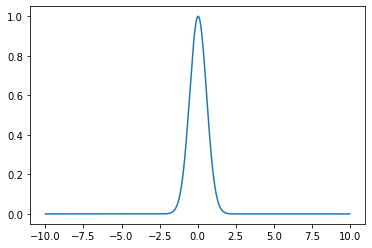

Distribution of the encrypted data : 


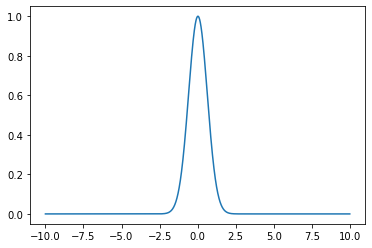

In [417]:
normal_distribution  = lambda x , mean, varience : np.exp(-np.square((x-mean)/(2*var)) / np.sqrt(2 * np.pi * var))

def plot_normal_dist(var,mean,rmin=-10,rmax=10): 
    x = np.arange(rmin,rmax,0.01)
    y = normal_distribution(x,mean,var)
    plt.plot(x,y)
    

#distribution on plain data
model = LogReg(n_features)
data = model.linear(x_test)
mean,var = map(float,[data.mean(),data.std()**2])
print(mean,var)
plot_normal_dist(var,mean)
print('Distribution on plain data : ')
plt.show()

#distribution on encrypted data 
enc_eval_log_reg = EncryptedLogReg(model.linear)
#encrypting the weight and the bias 
enc_eval_log_reg.encrypt(train_context)

weight = enc_eval_log_reg.weight
bias = enc_eval_log_reg.bias
data = []
for enc_x in enc_x_train: 
    enc_out = enc_x.dot(weight) + bias
    data.append(enc_out.decrypt())
    
data = torch.tensor(data)
mean , var = map(float,[data.mean(),data.std()**2])
plot_normal_dist(var,mean)
print("Distribution of the encrypted data : ")
plt.show()

we see that the most of the data are in the range of [-5,5] so the approximation of the sigmoid will work fine 

Now it's time to train the model on encrypted data : 
        
    and for that we will create the ecnrypted evaluation model and encrypt the weight and the bias 
    after that we will go into our encrypted data (enc_x_train & enc_y_test) and give each encrypted vector to the model using the forward() and the backward() fonctions to update the delta_weight and delta_bias
    in the end of every epoch we will update the params and calculate the accuracy 
    
    We can see that we decrypt the weights and re-encrypt them again after every epoch, this is necessary since after    updating the weights at the end of the epoch, we can no longer use them to perform enough multiplications, so we need to get them back to the initial ciphertext level. 
    
    In a real scenario, this would translate to sending the weights back to the secret-key holder for decryption and re-encryption. In that case, it will result in just a few Kilobytes of communication per epoch. 

In [422]:
def encrypted_train(context,enc_model,enc_x_train,enc_y_train,x_test,y_test,epochs):
    accuracy = enc_model.plain_accuracy(x_test,y_test)
    print(f"The accuracy in the epoch 0 : {accuracy}")
    times = []
    for epoch in range(1,epochs+1): 
        print(f"Epoch : {epoch} started")
        #encrypting the weight and the bias
        enc_model.encrypt(context)
        start_time = time()
        for enc_x,enc_y in zip(enc_x_train,enc_y_train): 
            enc_out = enc_model.forward(enc_x)
            enc_model.backward(enc_x,enc_out,enc_y)
        #in the end of the tarining for each epoch, we update the params
        enc_model.update_params()
        end_time = time()
        times.append(end_time - start_time)

        #we will decrypt the weights 
        enc_model.decrypt()
        accuracy = enc_model.plain_accuracy(x_test,y_test)
        print(f"Accuracy at epoch {epoch} is : {accuracy}")
        
    return model,times,accuracy


    

In [423]:
encrypted_eval_model = EncryptedLogReg(LogReg(n_features).linear)
EPOCHS = 5
_,times,last_accuracy = encrypted_train(train_context,encrypted_eval_model,enc_x_train,enc_y_train,x_test,y_test,EPOCHS)

The accuracy in the epoch 0 : 0.5329341292381287
Epoch : 1 started
[0.2743434872508937, 0.3919851277753926, 0.26577781108898924, 0.18104249822245477, -0.07827368080198978, 0.033732655210451074, -0.040768814274010336, 0.10627981645340301, 0.15409583564150137]
Accuracy at epoch 1 is : 0.6257485151290894
Epoch : 2 started
[0.2638650444584193, 0.484294155819898, 0.2519811771501451, 0.1799487306394393, 0.05031786655143268, 0.09898348234881024, 0.10596657834571675, 0.10922168854950033, 0.19239415218460648]
Accuracy at epoch 2 is : 0.667664647102356
Epoch : 3 started
[0.259662451138717, 0.536869103660764, 0.24809780290485292, 0.17716489671945124, 0.1252830573979135, 0.13830150808065977, 0.1941114514263676, 0.10290455187156458, 0.2140530369721437]
Accuracy at epoch 3 is : 0.667664647102356
Epoch : 4 started
[0.2586526518994851, 0.5676534791690874, 0.24945128798624278, 0.173925311282206, 0.1699365571794293, 0.16315737609551306, 0.24948669476978869, 0.09326218022464601, 0.2277328457488124]
Accur

We see that the accuracy on plain_text is increasing from epoch to another so we get a result after tarining the encrypted Model on encrypted Data

In [424]:
print(f"The evaluation operation took : \n\t{int(sum(times))} seconds")
print(f"The average time per epoch is : \n\t{int(sum(times)) /len(times)} seconds")
print(f"The last accuracy is : \n\t{last_accuracy}")
print(f"The Accaccuracy on the plain text : {plain_accuracy})
print(f"The difference accuracy is : \n\t{plain_accuracy - last_accuracy }")
if (plain_accuracy - last_accuracy ) < 0 :
    print("Wooow, We got better accuracy when training on encrypted data !")

The evaluation operation took : 
	1028 seconds
The average time per epoch is : 
	205.6 seconds
The last accuracy is : 
	0.682634711265564
The difference accuracy is : 
	-0.0029940009117126465


now we are going to train the same encrypted model on more epochs and see the evolution of the accuracy on the test set 

In [425]:
_,times,last_accuracy = encrypted_train(train_context,encrypted_eval_model,enc_x_train,enc_y_train,x_test,y_test,20)

The accuracy in the epoch 0 : 0.682634711265564
Epoch : 1 started
[0.26007704301940016, 0.5970840970462332, 0.2583154707032393, 0.16762159609024263, 0.21303398909044136, 0.19074457648346482, 0.31046554342378296, 0.07291962848978555, 0.24437927805554954]
Accuracy at epoch 1 is : 0.6856287717819214
Epoch : 2 started
[0.26113917155911015, 0.6037230911984536, 0.2635359936367491, 0.16481320465339996, 0.22260036498004843, 0.19861392693325242, 0.3278767993096683, 0.06381794317297329, 0.25003150625224396]
Accuracy at epoch 2 is : 0.6796407103538513
Epoch : 3 started
[0.26206759306652805, 0.6076535059972915, 0.268590113698291, 0.16228356374687686, 0.22801690644564152, 0.2042841123748781, 0.34058479490426635, 0.055743506481025856, 0.25469772014295416]
Accuracy at epoch 3 is : 0.682634711265564
Epoch : 4 started
[0.2627797083388491, 0.6099104419009286, 0.2732710257900994, 0.1600331086776492, 0.23081184849607878, 0.2084573401163604, 0.35018067406110154, 0.04870409135676697, 0.2586657580648214]
Acc

In [427]:
print(f"The evaluation operation took : \n\t{int(sum(times))} seconds")
print(f"The average time per epoch is : \n\t{int(sum(times)) /len(times)} seconds")
print(f"The last accuracy is : \n\t{last_accuracy}")
print(f"The Accaccuracy on the plain text : {plain_accuracy}")
print(f"The difference accuracy is : \n\t{plain_accuracy - last_accuracy }")
if (plain_accuracy - last_accuracy ) < 0 :
    print("Wooow, We got better accuracy when training on encrypted data !")

The evaluation operation took : 
	3759 seconds
The average time per epoch is : 
	187.95 seconds
The last accuracy is : 
	0.6796407103538513
The Accaccuracy on the plain text : 0.6796407103538513
The difference accuracy is : 
	0.0
